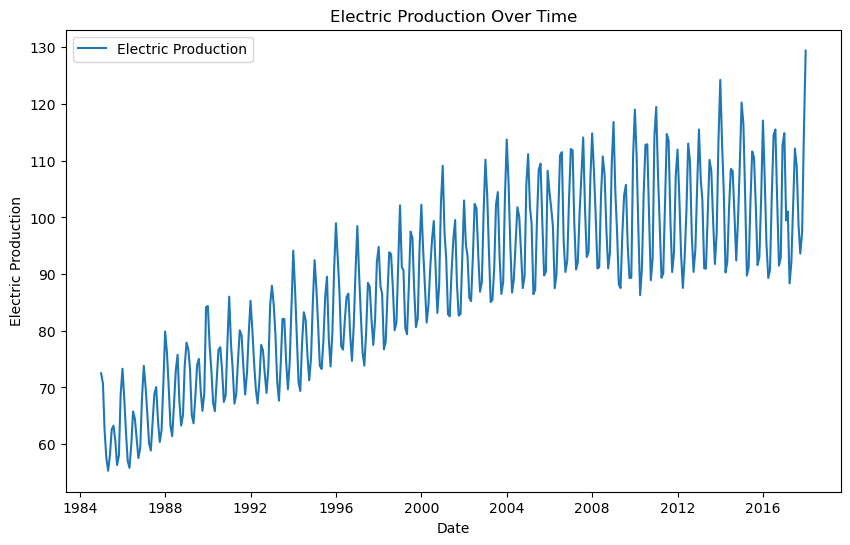

Missing Values:
 Electric_Production    0
dtype: int64
Summary Statistics:
        Electric_Production
count           397.000000
mean             88.847218
std              15.387834
min              55.315100
25%              77.105200
50%              89.779500
75%             100.524400
max             129.404800
ADF Test for Electric Production:
ADF Statistic: -2.256990350047245
p-value: 0.1862146911658677
Non-Stationary

ADF Test for Differenced Electric Production:
ADF Statistic: -7.104890882267318
p-value: 4.0777865655392766e-10
Stationary

Train Data Shape: (315, 3)
Test Data Shape: (79, 3)

VAR Model Summary:

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 15, Apr, 2025
Time:                     12:41:56
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -130.073
Nobs:                     314.000    HQIC:                 

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


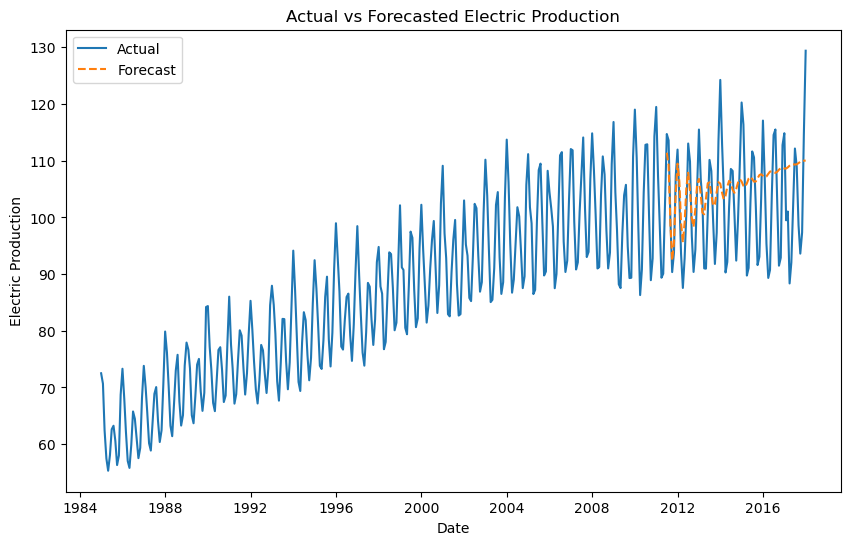


Mean Absolute Error (MAE): 7.65
Root Mean Squared Error (RMSE): 9.34


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Load and Preprocess Data
# Load the dataset
data = pd.read_csv(r"D:\Downloads\Electric_Production.csv")

# Convert DATE to datetime and set as index
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

# Rename column for clarity
data.rename(columns={'IPG2211A2N': 'Electric_Production'}, inplace=True)

# Step 2: Exploratory Data Analysis (EDA)
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(data['Electric_Production'], label='Electric Production')
plt.title('Electric Production Over Time')
plt.xlabel('Date')
plt.ylabel('Electric Production')
plt.legend()
plt.show()

# Check for missing values
print("Missing Values:\n", data.isnull().sum())

# Summary statistics
print("Summary Statistics:\n", data.describe())

# Step 3: Check Stationarity
def adf_test(series, title=''):
    result = adfuller(series.dropna())
    print(f'ADF Test for {title}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Stationary' if result[1] < 0.05 else 'Non-Stationary')
    print()

adf_test(data['Electric_Production'], 'Electric Production')

# Apply differencing if non-stationary
data_diff = data.diff().dropna()

# Re-check stationarity after differencing
adf_test(data_diff['Electric_Production'], 'Differenced Electric Production')

# Step 4: Prepare Data for VAR
# Create lagged variables to simulate multivariate data
var_data = pd.DataFrame({
    'Electric_Production': data_diff['Electric_Production'],
    'Lag1': data_diff['Electric_Production'].shift(1),
    'Lag2': data_diff['Electric_Production'].shift(2)
}).dropna()

# Step 5: Split Data into Training and Testing Sets
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(var_data) * 0.8)
train_data = var_data.iloc[:train_size]
test_data = var_data.iloc[train_size:]

print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)

# Step 6: Fit the VAR Model
# Fit VAR model
model = VAR(train_data)
model_fitted = model.fit(maxlags=12, ic='aic')  # Select lag based on AIC

# Summary of the model
print("\nVAR Model Summary:\n")
print(model_fitted.summary())

# Step 7: Forecasting
# Forecast for the test period
forecast_steps = len(test_data)
forecast = model_fitted.forecast(train_data.values[-model_fitted.k_ar:], steps=forecast_steps)

# Convert forecast to DataFrame (only take the first column for Electric_Production)
forecast_index = test_data.index
forecast_df = pd.DataFrame(forecast[:, 0], index=forecast_index, columns=['Forecast'])

# Reverse differencing to get original scale
last_observed = data['Electric_Production'].iloc[len(data) - len(test_data) - 1]
forecast_df['Forecast'] = last_observed + forecast_df['Forecast'].cumsum()

# Plot actual vs forecast
plt.figure(figsize=(10, 6))
plt.plot(data['Electric_Production'], label='Actual')
plt.plot(forecast_df['Forecast'], label='Forecast', linestyle='--')
plt.title('Actual vs Forecasted Electric Production')
plt.xlabel('Date')
plt.ylabel('Electric Production')
plt.legend()
plt.show()

# Step 8: Evaluate Model Performance
# Calculate evaluation metrics
actual = data['Electric_Production'].iloc[-len(test_data):]
mae = mean_absolute_error(actual, forecast_df['Forecast'])
rmse = np.sqrt(mean_squared_error(actual, forecast_df['Forecast']))

print(f'\nMean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')